In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import json
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import commons
import utils
from data_utils import TextAudioLoader, TextAudioCollate, TextAudioSpeakerLoader, TextAudioSpeakerCollate
from models import SynthesizerTrn
from text.symbols import symbols
from text import text_to_sequence

from scipy.io.wavfile import write


def get_text(text, hps):
    text_norm = text_to_sequence(text, hps.data.text_cleaners)
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm

## LJ Speech

In [4]:
hps = utils.get_hparams_from_file("./configs/ljs_base.json")

In [5]:
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model).cuda()
_ = net_g.eval()

_ = utils.load_checkpoint("logs/ljs_base/G_80000.pth", net_g, None)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 99.41 MiB already allocated; 16.06 MiB free; 100.00 MiB reserved in total by PyTorch)

In [5]:
stn_tst = get_text("VITS is Awesome!", hps)
with torch.no_grad():
    x_tst = stn_tst.cuda().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cuda()
    audio = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate, normalize=False))

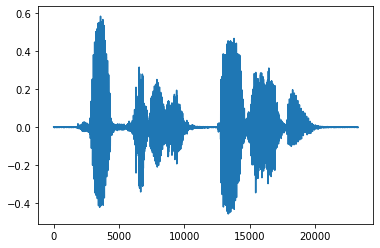

In [7]:
plt.plot(audio)

## VCTK

In [ ]:
hps = utils.get_hparams_from_file("./configs/vctk_base.json")

In [ ]:
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    n_speakers=hps.data.n_speakers,
    **hps.model).cuda()
_ = net_g.eval()

_ = utils.load_checkpoint("/path/to/pretrained_vctk.pth", net_g, None)

In [ ]:
stn_tst = get_text("VITS is Awesome!", hps)
with torch.no_grad():
    x_tst = stn_tst.cuda().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cuda()
    sid = torch.LongTensor([4]).cuda()
    audio = net_g.infer(x_tst, x_tst_lengths, sid=sid, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate, normalize=False))

### Voice Conversion

In [ ]:
dataset = TextAudioSpeakerLoader(hps.data.validation_files, hps.data)
collate_fn = TextAudioSpeakerCollate()
loader = DataLoader(dataset, num_workers=8, shuffle=False,
    batch_size=1, pin_memory=True,
    drop_last=True, collate_fn=collate_fn)
data_list = list(loader)

In [ ]:
with torch.no_grad():
    x, x_lengths, spec, spec_lengths, y, y_lengths, sid_src = [x.cuda() for x in data_list[0]]
    sid_tgt1 = torch.LongTensor([1]).cuda()
    sid_tgt2 = torch.LongTensor([2]).cuda()
    sid_tgt3 = torch.LongTensor([4]).cuda()
    audio1 = net_g.voice_conversion(spec, spec_lengths, sid_src=sid_src, sid_tgt=sid_tgt1)[0][0,0].data.cpu().float().numpy()
    audio2 = net_g.voice_conversion(spec, spec_lengths, sid_src=sid_src, sid_tgt=sid_tgt2)[0][0,0].data.cpu().float().numpy()
    audio3 = net_g.voice_conversion(spec, spec_lengths, sid_src=sid_src, sid_tgt=sid_tgt3)[0][0,0].data.cpu().float().numpy()
print("Original SID: %d" % sid_src.item())
ipd.display(ipd.Audio(y[0].cpu().numpy(), rate=hps.data.sampling_rate, normalize=False))
print("Converted SID: %d" % sid_tgt1.item())
ipd.display(ipd.Audio(audio1, rate=hps.data.sampling_rate, normalize=False))
print("Converted SID: %d" % sid_tgt2.item())
ipd.display(ipd.Audio(audio2, rate=hps.data.sampling_rate, normalize=False))
print("Converted SID: %d" % sid_tgt3.item())
ipd.display(ipd.Audio(audio3, rate=hps.data.sampling_rate, normalize=False))